I am adding the needed imports

In [2]:
import pandas as pd
import re
import nltk
import string
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


Βήμα 1: Φόρτωση και Εξέταση Δεδομένων 

In [7]:
dataset = pd.read_excel("new_labeled_dataset_withNOs.xlsx", engine="openpyxl")
#Συγχώνευση σε δύο κλάσεις: no και hate_speech
# Αν η κλάση είναι "no", την κρατάμε ως έχει.
# Αλλιώς, οτιδήποτε άλλο το κάνουμε "hate_speech".
dataset['binary_label'] = dataset['class_label'].apply(lambda x: 'no' if x == 'no' else 'hate_speech')
print("Πρώτες γραμμές του dataset:")
print(dataset.head())
print("\nΠληροφορίες του dataset:")
print(dataset.info())
print("\nΑριθμός κενών τιμών ανά στήλη:")
print(dataset.isnull().sum())

Πρώτες γραμμές του dataset:
                                                text  class_label binary_label
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...  hate_speech  hate_speech
1                                       Στα τέσσερα.           no           no
2                                 Στα τέσσερα εσείς.           no           no
3                                       Στα τέσσερα.           no           no
4                                            Λοιπόν.           no           no

Πληροφορίες του dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          866 non-null    object
 1   class_label   866 non-null    object
 2   binary_label  866 non-null    object
dtypes: object(3)
memory usage: 20.4+ KB
None

Αριθμός κενών τιμών ανά στήλη:
text            0
class_label     0
binary_label    0
dtype: int64


Βήμα 2: Καθαρισμός Κειμένου

In [8]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Αφαίρεση σημείων στίξης
    text = re.sub(r'\d+', '', text)      # Αφαίρεση αριθμών
    return text

dataset['cleaned_text'] = dataset['text'].apply(clean_text)
print("\nΠαραδείγματα καθαρισμένου κειμένου:")
print(dataset[['text', 'cleaned_text']].head())


Παραδείγματα καθαρισμένου κειμένου:
                                                text  \
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...   
1                                       Στα τέσσερα.   
2                                 Στα τέσσερα εσείς.   
3                                       Στα τέσσερα.   
4                                            Λοιπόν.   

                                        cleaned_text  
0  μιας πρότασης  σελίδων η οποία δεν έγινε χωρίς...  
1                                        στα τέσσερα  
2                                  στα τέσσερα εσείς  
3                                        στα τέσσερα  
4                                             λοιπόν  


Exploratory Data Analysis

Κατανομή κλάσεων:
no             736
hate_speech    130
Name: binary_label, dtype: int64


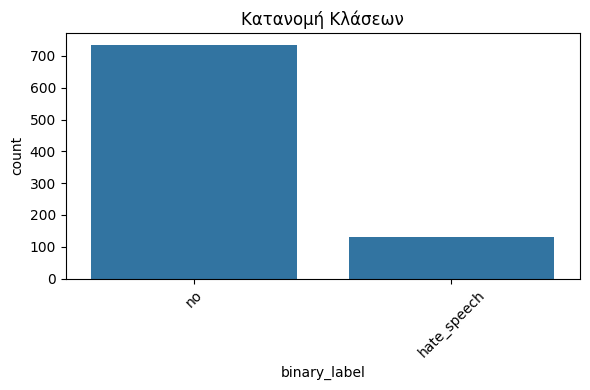


Στατιστικά μήκους κειμένου:
count    866.000000
mean       9.942263
std        8.717739
min        1.000000
25%        4.000000
50%        7.000000
75%       13.000000
max       68.000000
Name: text_length, dtype: float64


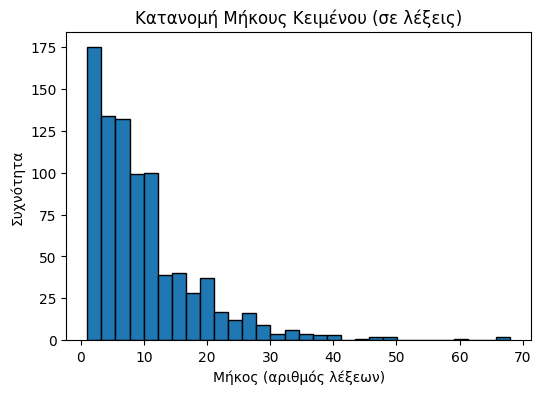


Οι 20 πιο συχνές λέξεις:
[('να', 322), ('και', 260), ('το', 244), ('δεν', 235), ('είναι', 198), ('που', 152), ('θα', 116), ('η', 109), ('με', 108), ('την', 106), ('τα', 101), ('αυτό', 95), ('ότι', 95), ('για', 90), ('ο', 85), ('εγώ', 75), ('της', 74), ('σε', 73), ('μου', 73), ('από', 69)]


[nltk_data] Downloading package punkt to /Users/annatolia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annatolia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


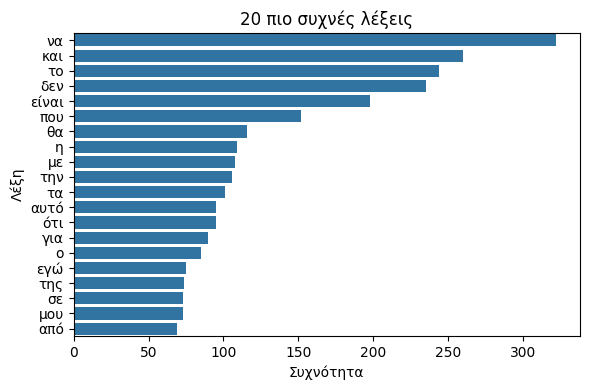

In [9]:
#Κατανομή κλάσης (Class Distribution)
print("Κατανομή κλάσεων:")
print(dataset['binary_label'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(data=dataset, x='binary_label', order=dataset['binary_label'].value_counts().index)
plt.title("Κατανομή Κλάσεων")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Μήκος κειμένου (π.χ. αριθμός λέξεων)
dataset['text_length'] = dataset['cleaned_text'].apply(lambda x: len(x.split()))
print("\nΣτατιστικά μήκους κειμένου:")
print(dataset['text_length'].describe())

plt.figure(figsize=(6, 4))
plt.hist(dataset['text_length'], bins=30, edgecolor='black')
plt.title("Κατανομή Μήκους Κειμένου (σε λέξεις)")
plt.xlabel("Μήκος (αριθμός λέξεων)")
plt.ylabel("Συχνότητα")
plt.show()

# Συχνότητα λέξεων
# Tokenization στο cleaned_text (εάν το θες για ανάλυση συχνότητας)
# Κατέβασμα απαραίτητων πόρων του nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt', quiet=True)
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

all_tokens = [word for row in dataset['tokens'] for word in row]
counter = Counter(all_tokens)
print("\nΟι 20 πιο συχνές λέξεις:")
print(counter.most_common(20))

# Προαιρετικά, μπορείς να φτιάξεις και ένα απλό barplot για τις πιο συχνές λέξεις:
common_words = counter.most_common(20)
words, freqs = zip(*common_words)
plt.figure(figsize=(6, 4))
sns.barplot(x=list(freqs), y=list(words))
plt.title("20 πιο συχνές λέξεις")
plt.xlabel("Συχνότητα")
plt.ylabel("Λέξη")
plt.tight_layout()
plt.show()

Βήμα 3: Tokenization και Εφαρμογή Stopwords 

In [10]:
# Κατέβασμα απαραίτητων πόρων του nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Χρησιμοποίησε το καθαρισμένο κείμενο για tokenization
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# (Προαιρετικά) Αφαίρεση πιθανών υπολειπόμενων σημείων στίξης ή αριθμών
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in string.punctuation and not word.isdigit()]
)

# Ορισμός και προσαρμογή λίστας stopwords στα Ελληνικά
default_stopwords = set(stopwords.words('greek'))
extra_stopwords = {
    'να', 'και', 'το', 'είναι', 'δεν', 'που', 'την', 'με', 'θα', 'η', 'τα', 'ότι', 'για',
    'μου', 'της', 'αυτό', 'σε', 'από', 'ο', 'Δεν', 'τη', 'τον', 'οι', 'του', 'στην', 'τους',
    'ένα', 'μας', 'στο', 'εγώ', 'έχει', 'σας', 'Και', 'σου', 'τώρα', 'μια', 'Εγώ', 'γιατί',
    'των', 'τι', 'αν', 'αυτή', 'πολύ', 'Να', 'κάτι', 'αυτά', 'Είναι'
}
custom_stopwords = default_stopwords - {"αυτός", "αυτή", "αυτοί"}
custom_stopwords.update(extra_stopwords)

# Ορισμός σημαντικών λέξεων που θέλουμε να κρατήσουμε
important_words = {"ρατσισμός", "σεξισμός", "ξενοφοβία", "κατά", "δικαιώματα", "προσβολή", "διάκριση",
                   "γυναίκα", "άντρας", "μαύρος", "λευκός", "ξένος", "αλλοδαπός"}
custom_stopwords = {word for word in custom_stopwords if word not in important_words}

print("\nΤελική λίστα stopwords:")
print(custom_stopwords)

# Αφαίρεση stopwords από τα tokens
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stopwords]
)

print("\nΠαραδείγματα tokens μετά την εφαρμογή stopwords:")
print(dataset[['cleaned_text', 'tokens']].head())


Τελική λίστα stopwords:
{'μην', 'τίσ', 'ότι', 'οὕτω', 'οἳ', 'ὑπὸ', 'ἐφ', 'ὅτε', 'τοί', 'δεν', 'ἐγώ', 'οι', 'τινα', 'εἰμὶ', 'σὺν', 'της', 'το', 'οὐκ', 'κατὰ', 'κατ', 'ἀφ', 'ὑπὲρ', 'εκεινοσ', 'ὑπ', 'τε', 'ταῖς', 'αυτοι', 'ἐάν', 'ἃ', 'τῷ', 'τῆσ', 'ἐκ', 'μή', 'δέ', 'τό', 'μὲν', 'αυτή', 'μετ', 'σας', 'μου', "δι'", 'τον', 'σύν', 'ἀπ', 'ἐγὼ', 'εἰ', 'εισαι', 'ποιων', 'τους', 'έχει', 'τὴν', 'αντι', 'ὦ', 'ἐμὸς', 'δαὶς', 'Εγώ', 'δή', 'δε', 'των', 'γάρ', 'σε', 'ἀλλά', 'τίς', 'μετά', 'γὰρ', 'ομωσ', 'τὸν', 'Να', 'τὸ', 'γε', 'ἢ', 'αυτη', 'τῶν', 'δαί', 'τισ', 'ὡσ', 'τοτε', 'αν', 'δαίσ', 'που', 'αυτα', 'οπωσ', 'οὐδ', 'κ', 'τὰς', 'από', 'δ’', 'πρὸ', 'τῇ', 'οὐδέ', 'τί', 'τόν', 'ἄλλος', "ἀλλ'", 'ποῦ', 'ποτε', 'ἡ', 'ποια', 'στη', 'ἄν', 'εκεινα', 'αἱ', 'οὕτως', 'κάτι', 'εγώ', 'ὅς', 'καί', 'παρὰ', 'θα', 'απο', 'ένα', 'γιατί', 'εἰς', 'επ', 'μα', 'αυτά', 'αὐτόσ', 'εκεινη', 'ποιουσ', 'πωσ', 'προσ', 'τα', 'εκεινουσ', 'οἱ', 'ἤ', 'ποιεσ', 'οὗτος', 'ποιοι', 'ποιο', 'εκεινο', 'και', 'οἷς', 'αὖ', 'μας', 'οὓς', 'ἐμόσ

[nltk_data] Downloading package punkt to /Users/annatolia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annatolia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Βήμα 4: Undersampling της Κλάσης "no" 

In [11]:
# Εμφάνιση κατανομής κλάσεων πριν το undersampling
print("\nΚατανομή κλάσεων πριν το undersampling:")
print(dataset['binary_label'].value_counts())

# Διαχωρισμός των δεδομένων για την κλάση "no" και τις υπόλοιπες κλάσεις
dataset_no = dataset[dataset['binary_label'] == 'no']
dataset_other = dataset[dataset['binary_label'] != 'no']

# Επιλογή 60 τυχαίων δειγμάτων από την κλάση "no"
dataset_no_sampled = dataset_no.sample(n=130, random_state=42)

# Ενοποίηση με τα δείγματα των υπόλοιπων κλάσεων
dataset_balanced = pd.concat([dataset_no_sampled, dataset_other]).reset_index(drop=True)
print("\nΚατανομή κλάσεων μετά το undersampling:")
print(dataset_balanced['binary_label'].value_counts())


Κατανομή κλάσεων πριν το undersampling:
no             736
hate_speech    130
Name: binary_label, dtype: int64

Κατανομή κλάσεων μετά το undersampling:
no             130
hate_speech    130
Name: binary_label, dtype: int64


Βήμα 5: Προετοιμασία Κειμένου για TF-IDF 

In [12]:
# Ενώνουμε τα tokens για κάθε δείγμα ώστε να δημιουργήσουμε το κείμενο για το TF-IDF
dataset_balanced['processed_text'] = dataset_balanced['tokens'].apply(lambda tokens: ' '.join(tokens))



Βήμα 6: Μετατροπή σε Χαρακτηριστικά με TF-IDF 

In [18]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(dataset_balanced['processed_text'])
y = dataset_balanced['binary_label']

print("\nΜορφή του TF-IDF Feature Matrix:", X.shape)


Μορφή του TF-IDF Feature Matrix: (260, 1091)


Βήμα 7: Ταξινόμηση με Leave-One-Out Cross-Validation 

In [14]:
# Δημιουργούμε ένα pipeline που περιλαμβάνει μόνο την Logistic Regression
loo = LeaveOneOut()
pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000))
])

# Εφαρμογή Leave-One-Out Cross-Validation για πρόβλεψη
y_pred = cross_val_predict(pipeline, X, y, cv=loo)
cm = confusion_matrix(y, y_pred)

# Υπολογισμός μετρικών απόδοσης
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

print("\nΑποτελέσματα Απόδοσης:")
print("Precision (macro):", precision)
print("Recall (macro):   ", recall)
print("F1 (macro):       ", f1)
print("\nClassification report:")
print(classification_report(y, y_pred))



Αποτελέσματα Απόδοσης:
Precision (macro): 0.6584517509958975
Recall (macro):    0.6576923076923077
F1 (macro):        0.6572816540529333

Classification report:
              precision    recall  f1-score   support

 hate_speech       0.67      0.62      0.65       130
          no       0.65      0.69      0.67       130

    accuracy                           0.66       260
   macro avg       0.66      0.66      0.66       260
weighted avg       0.66      0.66      0.66       260



Confusion Matrix

Confusion Matrix:
[[81 49]
 [40 90]]


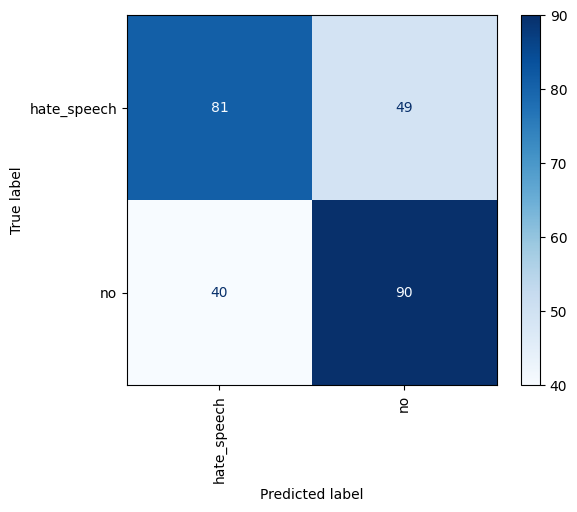

In [15]:
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')